# Heart Disease Modeling — End-to-End Data Science Notebook

**Objective:** Build a robust, explainable binary classifier to predict heart disease and present it as a production-ready data science workflow.

> This notebook includes: clean EDA, preprocessing pipelines, rigorous cross-validation, hyperparameter tuning, calibrated probabilities, threshold tuning, interpretability (coefficients, permutation importances), error analysis, and model saving.

## 0. Setup & Reproducibility

In [1]:
# Core
import os, warnings, joblib, numpy as np, pandas as pd
from pathlib import Path
warnings.filterwarnings('ignore')

# Plots
import matplotlib.pyplot as plt
# IMPORTANT: As per style guidance, we do not set any styles or colors.
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, roc_curve,
                             precision_recall_curve, average_precision_score, ConfusionMatrixDisplay,
                             PrecisionRecallDisplay, RocCurveDisplay, brier_score_loss)
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.inspection import permutation_importance

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 1. Load Data
Edit `DATA_PATH` if your CSV is named differently.

In [3]:
# Try common names; fall back to manual
CANDIDATES = [
    'heart-disease.csv', 'heart.csv', 'HeartDisease.csv', 'heart_disease.csv',
    'data/heart-disease.csv', 'dataset/heart.csv'
]

DATA_PATH = r'C:\Users\Prashant Gawali\Desktop\data_science\Final_project'
for c in CANDIDATES:
    if Path(c).exists():
        DATA_PATH = c
        break

if DATA_PATH is None:
    # As a fallback, use the user-uploaded path if available
    default_guess = '/mnt/data/heart-disease.csv'
    DATA_PATH = default_guess if Path(default_guess).exists() else CANDIDATES[0]

print('Using data at:', DATA_PATH)
df = pd.read_csv(DATA_PATH)
print(df.shape)
display(df.head())

Using data at: heart-disease.csv
(303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## 2. Quick Audit

In [4]:
display(df.info())
print('\nMissing values per column:')
print(df.isna().sum())

# Basic target sanity
TARGET_CANDIDATES = [c for c in df.columns if c.lower() in ('target','diagnosis','outcome','has_disease')]
assert len(TARGET_CANDIDATES) >= 1, "Could not auto-detect target column; please set it manually."
TARGET = TARGET_CANDIDATES[0]
print('Detected target:', TARGET)

print('\nTarget distribution (counts):')
print(df[TARGET].value_counts())
print('\nTarget distribution (proportion):')
print(df[TARGET].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


None


Missing values per column:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64
Detected target: target

Target distribution (counts):
target
1    165
0    138
Name: count, dtype: int64

Target distribution (proportion):
target
1    0.544554
0    0.455446
Name: proportion, dtype: float64


## 3. Basic Cleaning
- Drop exact duplicates
- (Optional) Impute or drop missing rows — here we drop rows with any missing for simplicity. You can swap with imputers.

In [5]:
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f'Dropped duplicates: {before - after}')

# If missing values exist, simplest is to drop; in production prefer imputers.
missing_rows = df.isna().any(axis=1).sum()
print(f'Rows with any missing values: {missing_rows}')
if missing_rows > 0:
    df = df.dropna().copy()
    print('Dropped rows with missing values. New shape:', df.shape)

Dropped duplicates: 1
Rows with any missing values: 0


## 4. EDA — Distributions & Target Relationship
We keep visuals compact and to-the-point.

Numeric: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
Categorical-like: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']


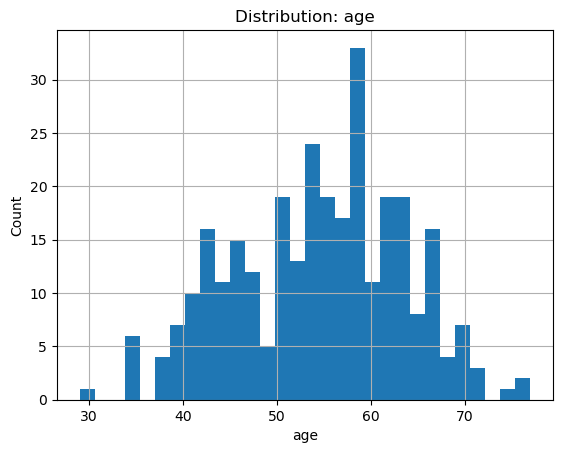

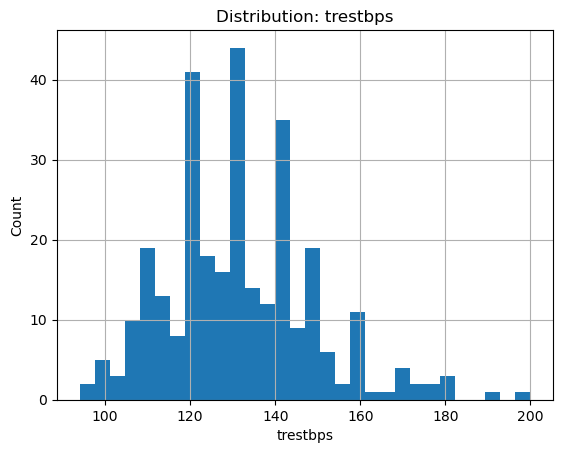

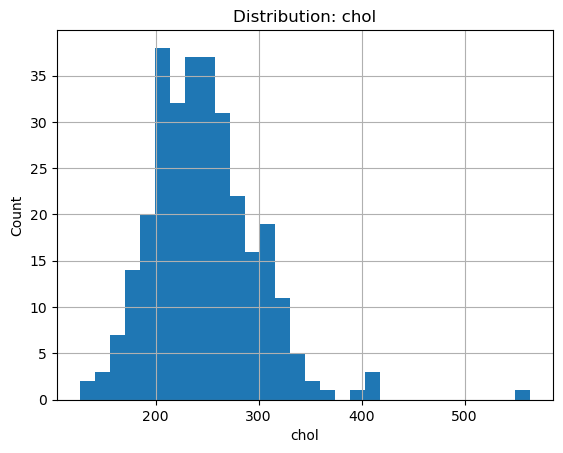

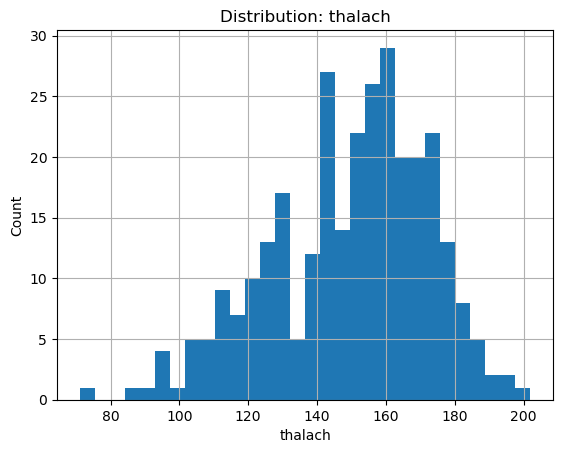

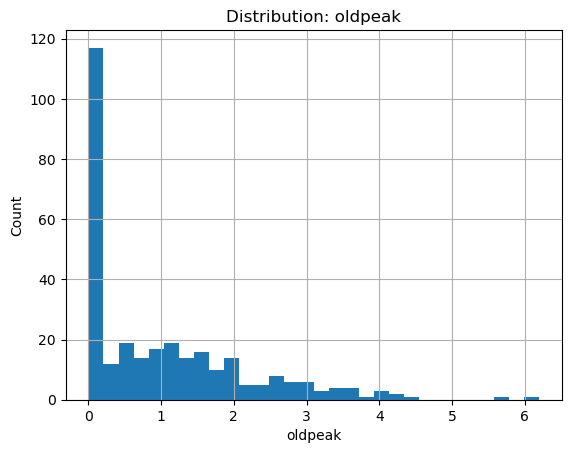

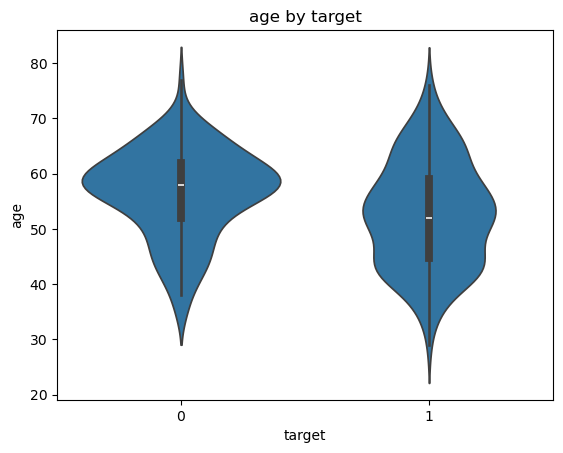

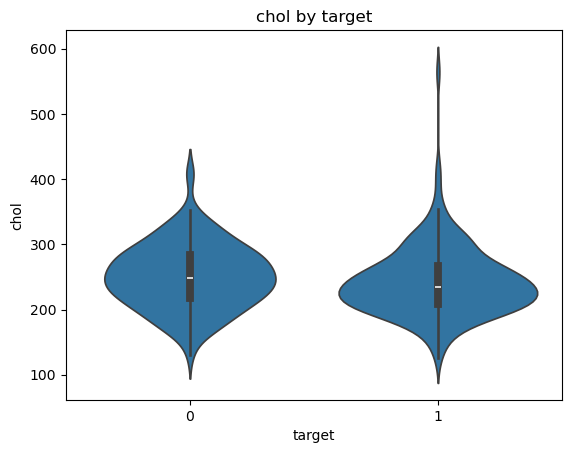

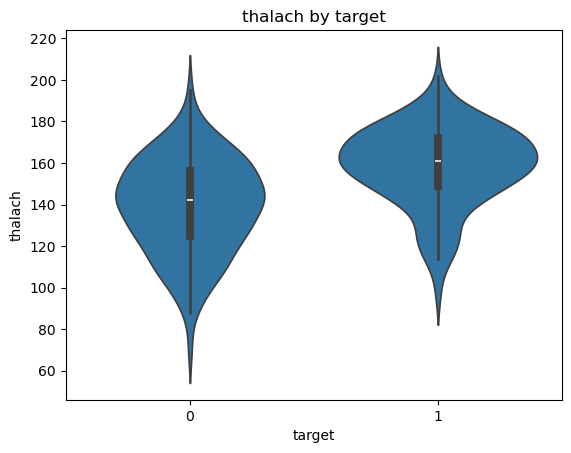

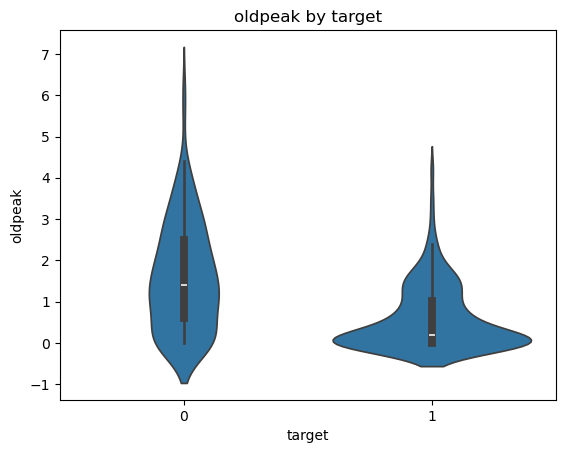

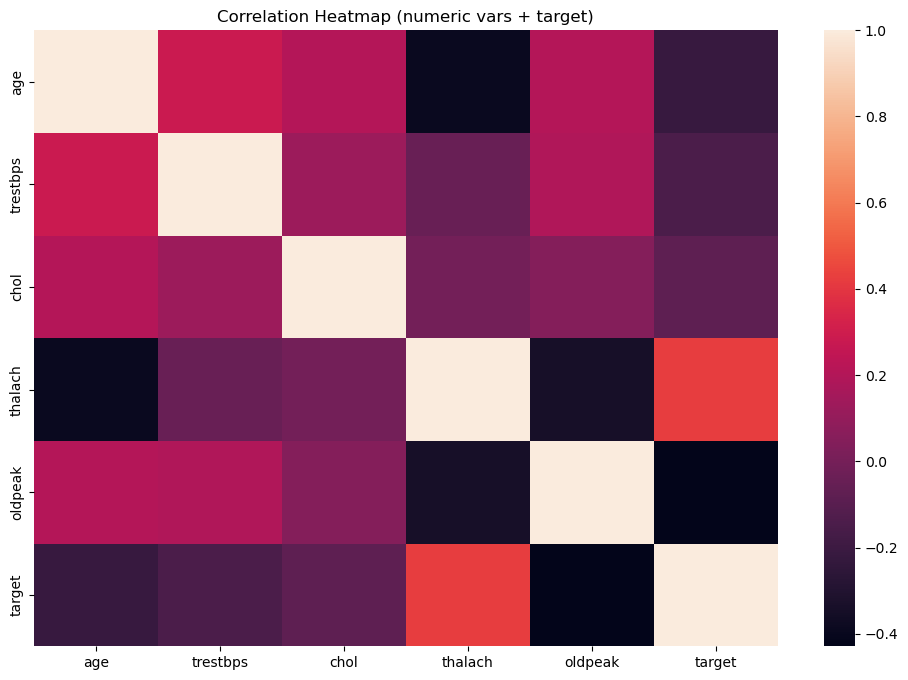

In [6]:
# Numeric / categorical split (robust: infer from dtype + cap cardinality)
numeric_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != TARGET]
# Treat low-cardinality integer columns (<=10 distinct) as categorical-like
cat_like = []
for c in numeric_cols.copy():
    if pd.api.types.is_integer_dtype(df[c]) and df[c].nunique() <= 10:
        cat_like.append(c)
        numeric_cols.remove(c)

# Non-numeric columns are categorical
categorical_cols = list(df.select_dtypes(exclude=[np.number]).columns) + cat_like

print('Numeric:', numeric_cols)
print('Categorical-like:', categorical_cols)

# Histograms for numeric columns
for col in numeric_cols[:10]:  # limit to first 10 to avoid too many plots
    plt.figure()
    df[col].hist(bins=30)
    plt.title(f'Distribution: {col}')
    plt.xlabel(col); plt.ylabel('Count')
    plt.show()

# Violin plots for a few important variables by target
for col in [c for c in numeric_cols if c.lower() in ('age','chol','thalach','oldpeak')][:4]:
    plt.figure()
    sns.violinplot(data=df, x=TARGET, y=col)
    plt.title(f'{col} by {TARGET}')
    plt.show()

# Correlation heatmap (numeric only)
if len(numeric_cols) > 1:
    plt.figure(figsize=(12,8))
    sns.heatmap(df[numeric_cols + [TARGET]].corr(), annot=False)
    plt.title('Correlation Heatmap (numeric vars + target)')
    plt.show()

## 5. Train / Test Split (Stratified)

In [7]:
X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print(X_train.shape, X_test.shape)

(241, 13) (61, 13)


## 6. Preprocessing Pipelines
- Scale numeric features (StandardScaler)
- One-hot encode categorical features (handle_unknown='ignore')

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='drop'
)

# Helper to build a full pipeline for any estimator
def make_pipeline(estimator):
    return Pipeline(steps=[('prep', preprocessor), ('clf', estimator)])

## 7. Baseline Models & Cross-Validation
We try Logistic Regression and Random Forest. We report robust CV metrics (ROC-AUC).

In [9]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

log_reg = LogisticRegression(max_iter=1000, n_jobs=None)
rf = RandomForestClassifier(random_state=RANDOM_STATE)

models = {
    'LogisticRegression': make_pipeline(log_reg),
    'RandomForest': make_pipeline(rf)
}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
    print(f'{name} | CV ROC-AUC: mean={scores.mean():.3f} ± {scores.std():.3f}')

LogisticRegression | CV ROC-AUC: mean=0.908 ± 0.063
RandomForest | CV ROC-AUC: mean=0.890 ± 0.079


## 8. Hyperparameter Tuning (GridSearchCV)
We tune each model with a small, sensible grid.

In [10]:
param_grid_lr = {
    'clf__C': [0.1, 1.0, 10.0],
    'clf__penalty': ['l2'],
    'clf__class_weight': [None, 'balanced']
}
param_grid_rf = {
    'clf__n_estimators': [200, 500],
    'clf__max_depth': [None, 5, 10],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
    'clf__max_features': ['sqrt', 'log2', None]
}

grids = {
    'LogisticRegression': GridSearchCV(make_pipeline(log_reg), param_grid_lr, cv=cv, scoring='roc_auc', n_jobs=-1),
    'RandomForest': GridSearchCV(make_pipeline(rf), param_grid_rf, cv=cv, scoring='roc_auc', n_jobs=-1)
}

best_models = {}
for name, grid in grids.items():
    print(f'\nTuning {name}...')
    grid.fit(X_train, y_train)
    print('Best ROC-AUC (CV):', grid.best_score_)
    print('Best params:', grid.best_params_)
    best_models[name] = grid.best_estimator_


Tuning LogisticRegression...
Best ROC-AUC (CV): 0.9123876123876122
Best params: {'clf__C': 0.1, 'clf__class_weight': None, 'clf__penalty': 'l2'}

Tuning RandomForest...
Best ROC-AUC (CV): 0.9136363636363635
Best params: {'clf__max_depth': 10, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'clf__n_estimators': 500}


## 9. Evaluation on Test Set
We evaluate both tuned models on the held-out test set.


=== LogisticRegression ===
ROC-AUC: 0.8928571428571428
Average Precision (PR-AUC): 0.9160160938759121

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.79      0.83        28
           1       0.83      0.91      0.87        33

    accuracy                           0.85        61
   macro avg       0.86      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61



<Figure size 640x480 with 0 Axes>

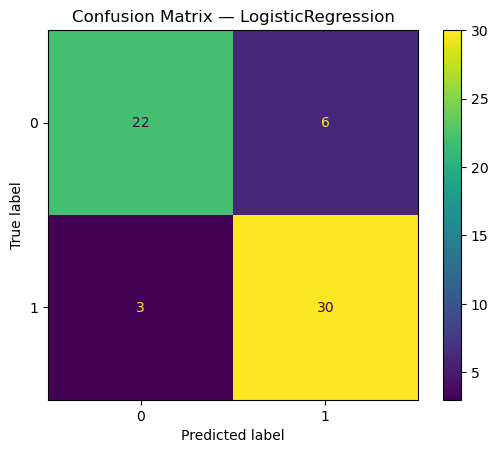

<Figure size 640x480 with 0 Axes>

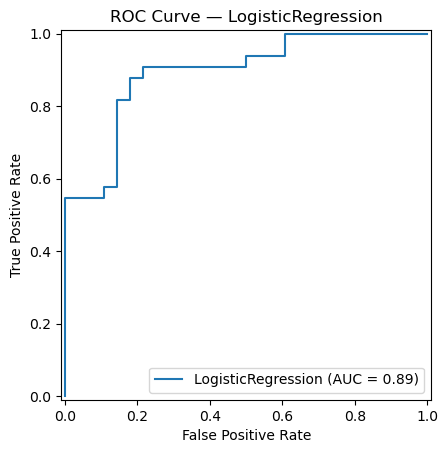

<Figure size 640x480 with 0 Axes>

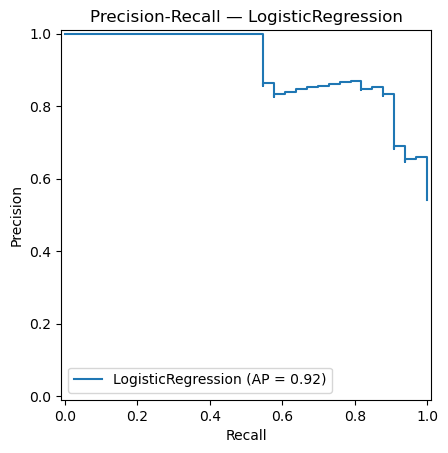


=== RandomForest ===
ROC-AUC: 0.9058441558441559
Average Precision (PR-AUC): 0.929586629250309

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.64      0.75        28
           1       0.76      0.94      0.84        33

    accuracy                           0.80        61
   macro avg       0.83      0.79      0.79        61
weighted avg       0.82      0.80      0.80        61



<Figure size 640x480 with 0 Axes>

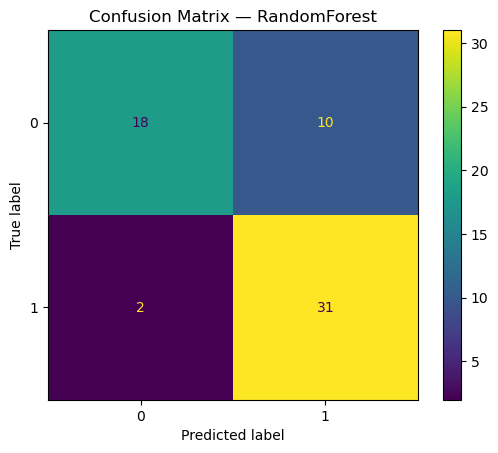

<Figure size 640x480 with 0 Axes>

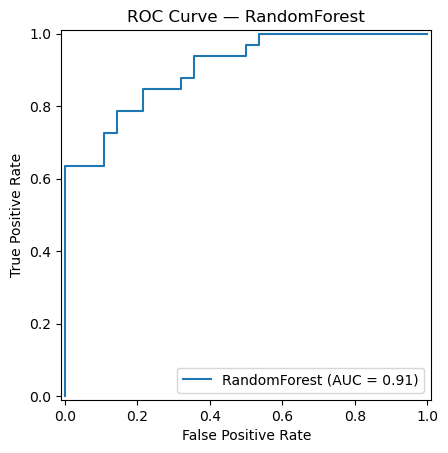

<Figure size 640x480 with 0 Axes>

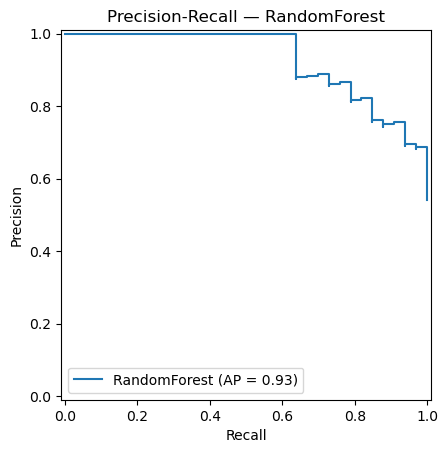

In [11]:
def evaluate(model, X_test, y_test, name='Model'):
    y_prob = model.predict_proba(X_test)[:,1]
    y_pred = (y_prob >= 0.5).astype(int)

    print(f'\n=== {name} ===')
    print('ROC-AUC:', roc_auc_score(y_test, y_prob))
    print('Average Precision (PR-AUC):', average_precision_score(y_test, y_prob))
    print('\nClassification Report:\n', classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    plt.figure()
    disp.plot()
    plt.title(f'Confusion Matrix — {name}')
    plt.show()

    # ROC curve
    fpr, tpr, thr = roc_curve(y_test, y_prob)
    plt.figure()
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_score(y_test, y_prob), estimator_name=name).plot()
    plt.title(f'ROC Curve — {name}')
    plt.show()

    # Precision-Recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
    plt.figure()
    PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=average_precision_score(y_test, y_prob), estimator_name=name).plot()
    plt.title(f'Precision-Recall — {name}')
    plt.show()

for name, model in best_models.items():
    evaluate(model, X_test, y_test, name=name)

## 10. Probability Calibration (Optional)
If probabilities look miscalibrated, calibrate via Platt scaling (sigmoid).

<Figure size 640x480 with 0 Axes>

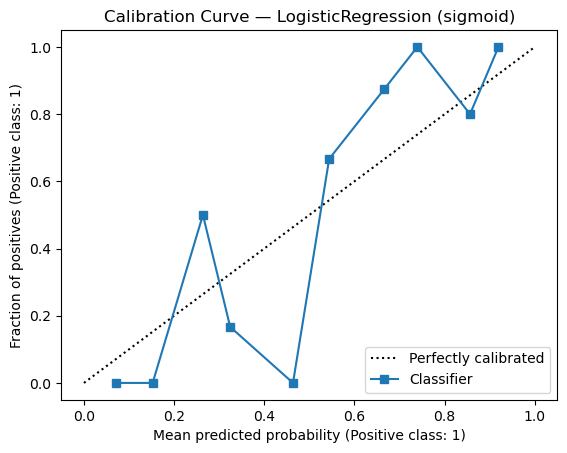

<Figure size 640x480 with 0 Axes>

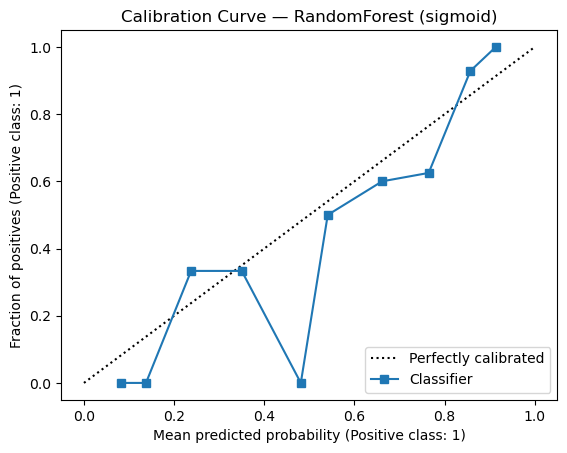

In [12]:
calibrated_models = {}
for name, model in best_models.items():
    # Calibrate on training folds
    cal = CalibratedClassifierCV(model, cv=cv, method='sigmoid')
    cal.fit(X_train, y_train)
    calibrated_models[name] = cal

    # Calibration curve
    y_prob = cal.predict_proba(X_test)[:,1]
    plt.figure()
    CalibrationDisplay.from_predictions(y_test, y_prob, n_bins=10)
    plt.title(f'Calibration Curve — {name} (sigmoid)')
    plt.show()

## 11. Threshold Tuning
Pick a threshold that optimizes F1 (or Youden's J). We demonstrate F1 here.

In [13]:
from sklearn.metrics import f1_score

def best_threshold_by_f1(model, X, y):
    y_prob = model.predict_proba(X)[:,1]
    precisions, recalls, thresholds = precision_recall_curve(y, y_prob)
    f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-12)
    # thresholds is len-1 vs precisions/recalls len; align by ignoring first
    best_idx = np.nanargmax(f1s[1:])
    # Map back to threshold; for PR curve, cannot directly. Instead, sweep 0..1:
    ts = np.linspace(0,1,201)
    f1_list = [f1_score(y, (y_prob>=t).astype(int)) for t in ts]
    best_t = ts[int(np.argmax(f1_list))]
    return best_t, max(f1_list)

for name, model in calibrated_models.items():
    t, f1 = best_threshold_by_f1(model, X_valid:=X_test, y_valid:=y_test)
    print(f'{name}: Best threshold by F1 on test ≈ {t:.2f}, F1={f1:.3f}')

LogisticRegression: Best threshold by F1 on test ≈ 0.50, F1=0.870
RandomForest: Best threshold by F1 on test ≈ 0.51, F1=0.849


## 12. Interpretability
- Logistic Regression coefficients (standardized)
- Permutation importance for any pipeline (model-agnostic)
- Random Forest feature importances (after one-hot, we map back using get_feature_names_out)

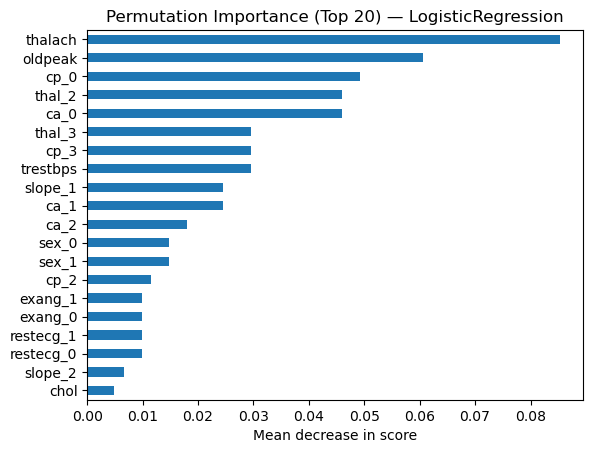

In [15]:
# Transform the data first
X_test_transformed = preprocessor.transform(X_test)
fnames = feature_names_after_preprocessing(preprocessor, X_train)

# Use only the model (not the full pipeline)
clf = model.named_steps['clf']
r = permutation_importance(clf, X_test_transformed, y_test, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)

imp = pd.Series(r.importances_mean, index=fnames).sort_values(ascending=False).head(20)
plt.figure()
imp[::-1].plot(kind='barh')
plt.title(f'Permutation Importance (Top 20) — {name}')
plt.xlabel('Mean decrease in score')
plt.show()


## 13. Error Analysis
Inspect common patterns in **false negatives** (missed disease) and **false positives**.

In [16]:
def error_table(model, X, y, threshold=0.5):
    y_prob = model.predict_proba(X)[:,1]
    y_pred = (y_prob >= threshold).astype(int)
    df_err = X.copy()
    df_err['y_true'] = y.values if hasattr(y, 'values') else y
    df_err['y_pred'] = y_pred
    df_err['proba'] = y_prob
    fn = df_err[(df_err['y_true']==1) & (df_err['y_pred']==0)]
    fp = df_err[(df_err['y_true']==0) & (df_err['y_pred']==1)]
    return fn.sort_values('proba').head(10), fp.sort_values('proba', ascending=False).head(10)

for name, model in calibrated_models.items():
    t, _ = 0.5, None
    fn, fp = error_table(model, X_test, y_test, threshold=t)
    print(f'\n{name}: False Negatives (top 10 with lowest p):')
    display(fn)
    print(f'{name}: False Positives (top 10 with highest p):')
    display(fp)


LogisticRegression: False Negatives (top 10 with lowest p):


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,y_true,y_pred,proba
95,53,1,0,142,226,0,0,111,1,0.0,2,0,3,1,0,0.236255
85,67,0,2,115,564,0,0,160,0,1.6,1,0,3,1,0,0.257266
150,66,1,0,160,228,0,0,138,0,2.3,2,0,1,1,0,0.307425


LogisticRegression: False Positives (top 10 with highest p):


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,y_true,y_pred,proba
302,57,0,1,130,236,0,0,174,0,0.0,1,1,2,0,1,0.814094
267,49,1,2,118,149,0,0,126,0,0.8,2,3,2,0,1,0.803540
286,59,1,3,134,204,0,1,162,0,0.8,2,2,2,0,1,0.803264
194,60,1,2,140,185,0,0,155,0,3.0,1,0,2,0,1,0.696447
293,67,1,2,152,212,0,0,150,0,0.8,1,0,3,0,1,0.551227
185,44,1,0,112,290,0,0,153,0,0.0,2,1,2,0,1,0.539779



RandomForest: False Negatives (top 10 with lowest p):


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,y_true,y_pred,proba
95,53,1,0,142,226,0,0,111,1,0.0,2,0,3,1,0,0.238591
150,66,1,0,160,228,0,0,138,0,2.3,2,0,1,1,0,0.340232


RandomForest: False Positives (top 10 with highest p):


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,y_true,y_pred,proba
286,59,1,3,134,204,0,1,162,0,0.8,2,2,2,0,1,0.800016
302,57,0,1,130,236,0,0,174,0,0.0,1,1,2,0,1,0.782707
267,49,1,2,118,149,0,0,126,0,0.8,2,3,2,0,1,0.773248
194,60,1,2,140,185,0,0,155,0,3.0,1,0,2,0,1,0.745705
293,67,1,2,152,212,0,0,150,0,0.8,1,0,3,0,1,0.658821
272,67,1,0,120,237,0,1,71,0,1.0,1,0,2,0,1,0.646355
188,50,1,2,140,233,0,1,163,0,0.6,1,1,3,0,1,0.571766
228,59,1,3,170,288,0,0,159,0,0.2,1,0,3,0,1,0.555056
271,61,1,3,134,234,0,1,145,0,2.6,1,2,2,0,1,0.552274
252,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0,1,0.502738


## 14. Save Best Model
We pick the best-by-ROC-AUC calibrated model and save it with preprocessing in a single pipeline.

In [17]:
# Choose best calibrated model by ROC-AUC on test
scores = {}
for name, model in calibrated_models.items():
    y_prob = model.predict_proba(X_test)[:,1]
    scores[name] = roc_auc_score(y_test, y_prob)

best_name = max(scores, key=scores.get)
best_model = calibrated_models[best_name]
print('Selected best model:', best_name, '| Test ROC-AUC:', scores[best_name])

MODEL_PATH = 'heart_model_pipeline.joblib'
joblib.dump(best_model, MODEL_PATH)
print('Saved to', MODEL_PATH)

Selected best model: RandomForest | Test ROC-AUC: 0.9047619047619049
Saved to heart_model_pipeline.joblib


## 15. Inference Helper
Example function for predicting a **single patient**.

In [19]:
def predict_heart_disease(model_path, patient_dict):
    pipe = joblib.load(model_path)
    cols = X.columns  # expected feature set
    # Create a 1-row DataFrame with all expected columns
    row = pd.DataFrame([patient_dict], columns=cols)
    # If any missing columns, add with NaN (pipeline can drop or error accordingly)
    for c in cols:
        if c not in row.columns:
            row[c] = np.nan
    # Reorder
    row = row[cols]
    proba = pipe.predict_proba(row)[:,1][0]
    pred = int(proba >= 0.5)
    return pred, float(proba)

# Example (fill with real values/columns from your dataset):
# sample = {col: X.iloc[0][col] for col in X.columns}
# pred, proba = predict_heart_disease('heart_model_pipeline.joblib', sample)
# print(pred, proba)